# Using Atlite to retrieve historical data and conversion to power generation potentials for South Africa's Renewable Energy Development Zones

This jupyter notebook documents how to retrieve historical weather data from Atlite and through a cutout and consequently gnerate profiles for wind and solar PV. The notebook is based on generation potentials for South Africa's Renewable Energy Development Zones (REDZs). Links are provided to download shape files for the REDZs provided at the Department of Forestry, Fisheries and the Environment of the Republic of South Africa. 

- Atlite is documented in https://joss.theoj.org/papers/10.21105/joss.03294
- Atlite tutorials are documented in https://github.com/PyPSA/atlite/tree/master/examples 
- Renewable Energy Development Zones (REDZs) shape files are located at https://egis.environment.gov.za/data_egis/data_download/current. A user profile is to be created before downloading the shape files.

Inputs:
- Shape file
    - Phase 1 and Phase 2 REDZs shape files from https://egis.environment.gov.za/data_egis/data_download/ 

Outputs:
- A cutout with spatio-temporal bounds given by extent of the REDZs at hourly intervals for the year 2013
- Cutout contains 


The dependencies required to read the shape files into geo pandas data frames are imported together with the atlite module.

In [1]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import xarray as xr
import atlite

from shapely.ops import unary_union
import numpy as np
import rasterio
import shapely
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
projection = ccrs.Orthographic(20, 0)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())

## Reading REDZs shape file

Download and unzip the files Phase1_REDZs.zip and Phase2_REDZs.zip from https://egis.environment.gov.za/data_egis/data_download/ .

The shape files have extension .shp and can be read into the jupyter notebook using geo pandas

In [2]:
REDZ_shapefile_1 = gpd.read_file('../data/supply_regions/supply_regions_27-supply.shp')
REDZ_shapefile_2 = gpd.read_file('../data/supply_regions/supply_regions_27-supply.shp')
resarea = gpd.read_file('../data/bundle/REDZ_DEA_Unpublished_Draft_2015/REDZ_DEA_Unpublished_Draft_2015.shp')
#REDZ_shapefile_1 = gpd.read_file('../data/bundle/REDZ_DEA_Unpublished_Draft_2015/REDZ_DEA_Unpublished_Draft_2015.shp')

The first shape file REDZ_shapefile_1 gives the 8 REDZs identified in Phase 1 while the second shape file REDZ_shapefile_1 gives 3 additional REDZs identified in Phase 2. The Phase 1 shape file is projected to a coordinate reference system 'epsg:32635' and then to 'epsg:4326' using the to_crs().

In [3]:
REDZ_shapefile_1 = REDZ_shapefile_1.to_crs('epsg:32635')
resarea = resarea.to_crs('epsg:32635')

To do a a single cutout using atlite which covers all the REDZs we create a geo data frame using geo pandas of the concatenated shape files. The shape files have different information so values with NAN are removed 

In [4]:
#unified_redz_shape = pd.concat([REDZ_shapefile_1.to_crs('epsg:4326'),REDZ_shapefile_2])
REDZ = REDZ_shapefile_1.to_crs('epsg:4326')
resarea = resarea.to_crs('epsg:4326')
#REDZ = gpd.GeoDataFrame(unified_redz_shape)
#REDZ = REDZ["geometry"][REDZ["geometry"].is_valid]

REDZ = gpd.GeoDataFrame(REDZ).set_index(REDZ.name)
REDZ = REDZ.rename(columns={0: "geometry"}).set_geometry("geometry")

unified_shape_file = unary_union(REDZ["geometry"])
unified_shape = gpd.GeoDataFrame(geometry=[unified_shape_file],crs=4326)

## Create a cutout with spatio-temporal bounds given by extent of the REDZs

Determine the extent of the cutout by determining the bounds of the unified_shape created above. Use the geographical bounds as input to the cutout

In [5]:
bounds = unified_shape.unary_union.bounds
cutout = atlite.Cutout(path="../cutouts/RSA-2012-era5_corrected.nc", # name of file to save cutout
                       module="era5", # database
                       bounds=bounds, # geographical bounds including all 27 regions
                       time=slice('2012-01-01', '2013-01-01')) # January 2011

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/atlite/cutout.py:187: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


To prepare the cutout follow the exaple given in the atlite documentation especially setting up of the ADS key. Prepare the cutup. This is the time consuming step as all the data from the is retrieved here. 

In [6]:
cutout.prepare()
cells = cutout.grid

The cutout region and the REDZs are plotted following the examples from atlite

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_52617/2128976501.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


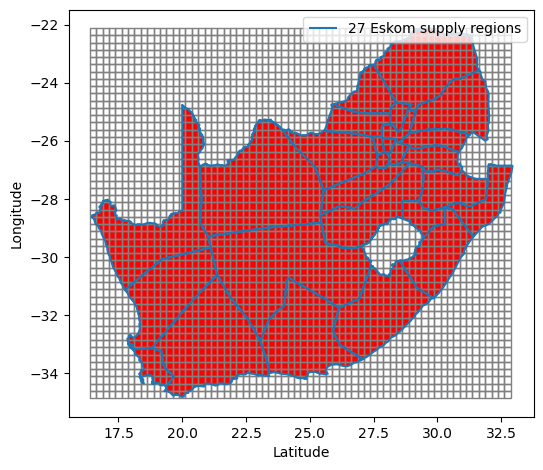

In [7]:
fig, ax = plt.subplots(figsize=(6,6));
unified_shape.plot(ax=ax, label='REDZs',color='Red');
cutout.grid.plot(ax=ax, edgecolor='grey', color='None', label='Cutout geographical bounds');

supply_regions_shapefile = shpreader.Reader('../data/supply_regions/supply_regions_27-supply.shp')

supply_regions = gpd.GeoSeries({r.attributes['name']: r.geometry
                      for r in supply_regions_shapefile.records()},
                      crs={'init': 'epsg:4326'}
                     )
supply_regions.boundary.plot(ax=ax, label='27 Eskom supply regions')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.legend()

In [8]:
# Create exclusion container to exclude SAPAD and SACAD from the shape file. Available area is also
# shown
cap_per_sqkm = 1.7 #

excluder = atlite.ExclusionContainer()
excluder.add_geometry('../data/bundle/SACAD_OR_2017_Q2/SACAD_OR_2017_Q2.shp')
excluder.add_geometry('../data/bundle/SAPAD_OR_2017_Q2/SAPAD_OR_2017_Q2.shp')

availability_matrix = cutout.availabilitymatrix(REDZ.to_crs(excluder.crs),excluder)

area = cutout.grid.to_crs(3035).area / 1e6
area = xr.DataArray(area.values.reshape(cutout.shape),
                        [cutout.coords['y'], cutout.coords['x']])
potential = availability_matrix * area * cap_per_sqkm


Compute availability matrix: 100%|██████████| 27/27 [00:07<00:00,  3.76 gridcells/s]


# Wind power analysis

In [9]:
capacity_factor = cutout.wind(turbine='NREL_ReferenceTurbine_2020ATB_4MW',capacity_factor=True)
layout = capacity_factor * area * cap_per_sqkm

profile_wind, capacities_wind = cutout.wind('NREL_ReferenceTurbine_2020ATB_4MW',matrix=availability_matrix.stack(spatial=['y','x']),
                                layout=layout, index=REDZ.index,
                                per_unit=True, return_capacity=True)

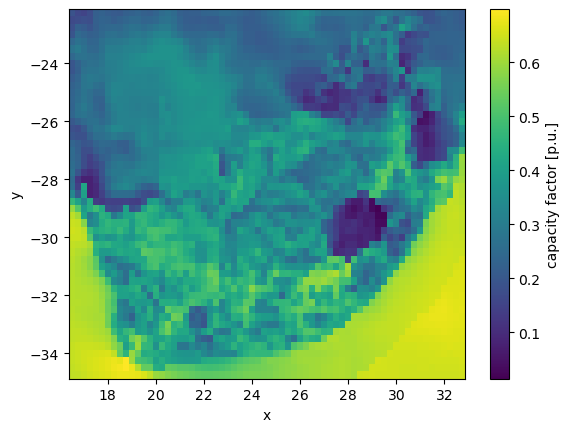

In [10]:
capacity_factor.plot()

In [11]:
CSIR=pd.read_excel('../data/bundle/Supply area normalised power feed-in for Wind.xlsx',index_col=[0],skiprows=[1],sheet_name = 'Wind power profiles',parse_dates=True)

In [12]:
CF=pd.DataFrame(0,index=profile_wind.to_pandas().columns,columns=['CSIR','Atlite'])
CF['CSIR']=CSIR.loc[str('2012'),:].mean()
CF['Atlite']=profile_wind.to_pandas().mean()*0.92

<AxesSubplot: xlabel='name'>

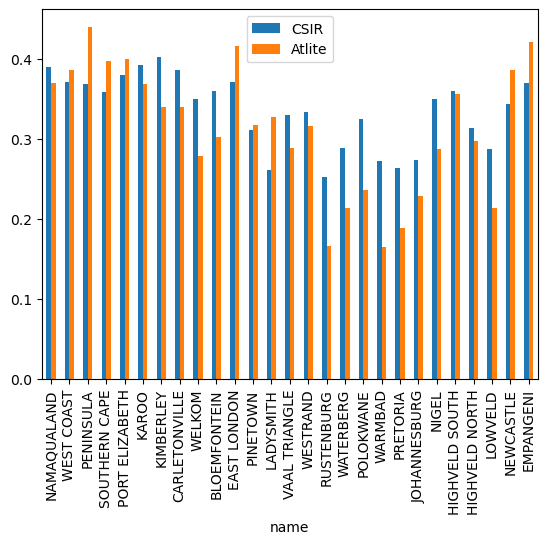

In [13]:
CF.plot.bar()

In [37]:
cf = capacity_factor.to_pandas()
cf[cf>0.2] = 1
cf[cf<=0.2] = 0
for redz_loc in range(0,len(availability_matrix.coords['name'])):
    availability_matrix.values[redz_loc,:,:] = np.multiply(availability_matrix.values[redz_loc,:,:],cf)

In [19]:
capacity_factor = cutout.wind(turbine='Vestas_V112_3MW',capacity_factor=True)
layout = capacity_factor * area * cap_per_sqkm

In [20]:
profile_wind, capacities_wind = cutout.wind('Vestas_V112_3MW',matrix=availability_matrix.stack(spatial=['y','x']),
                                layout=layout, index=REDZ.index,
                                per_unit=True, return_capacity=True)

In [21]:
profile_wind.to_pandas().mean()

name
NAMAQUALAND       0.329542
WEST COAST        0.342290
PENINSULA         0.390586
SOUTHERN CAPE     0.357119
PORT ELIZABETH    0.358881
KAROO             0.320972
KIMBERLEY         0.283901
CARLETONVILLE     0.277868
WELKOM            0.222160
BLOEMFONTEIN      0.248429
EAST LONDON       0.377593
PINETOWN          0.283627
LADYSMITH         0.305789
VAAL TRIANGLE     0.235295
WESTRAND          0.260450
RUSTENBURG        0.214637
WATERBERG         0.188991
POLOKWANE         0.201899
WARMBAD           0.209031
PRETORIA          0.171097
JOHANNESBURG      0.193587
NIGEL             0.229520
HIGHVELD SOUTH    0.297782
HIGHVELD NORTH    0.248611
LOWVELD           0.207873
NEWCASTLE         0.341386
EMPANGENI         0.364698
dtype: float64

In [22]:
# Prepare the cut-out. Commented out as cutout is already downloaded.
#cutout.prepare()

profile_pv, capacities_pv = cutout.pv(panel='CSi', orientation='latitude_optimal',matrix=availability_matrix.stack(spatial=['y','x']),
                                layout=layout, index=REDZ.index,
                                per_unit=True, return_capacity=True)



In [23]:
capacity_factor = cutout.wind(turbine='Vestas_V112_3MW',capacity_factor=True)
layout = capacity_factor * area * cap_per_sqkm

In [24]:
cf = capacity_factor.to_pandas()
cf[cf>0.3] = 1
cf[cf<=0.3] = 0
for redz_loc in range(0,len(availability_matrix.coords['name'])):
    availability_matrix.values[redz_loc,:,:] = np.multiply(availability_matrix.values[redz_loc,:,:],cf)

In [25]:
layout = capacity_factor * area * cap_per_sqkm

In [26]:
profile_pv, capacities_pv = cutout.pv(panel='CSi', orientation='latitude_optimal',matrix=availability_matrix.stack(spatial=['y','x']),
                                layout=layout, index=REDZ.index,
                                per_unit=True, return_capacity=True)

In [27]:
profile_wind2, capacities_wind2 = cutout.wind('Vestas_V112_3MW',matrix=availability_matrix.stack(spatial=['y','x']),
                                layout=layout, index=REDZ.index,
                                per_unit=True, return_capacity=True)

In [28]:
profile_wind2.to_pandas().mean()

name
NAMAQUALAND       0.359036
WEST COAST        0.364998
PENINSULA         0.383068
SOUTHERN CAPE     0.371930
PORT ELIZABETH    0.377759
KAROO             0.357222
KIMBERLEY         0.320541
CARLETONVILLE     0.323564
WELKOM            0.000000
BLOEMFONTEIN      0.338151
EAST LONDON       0.398315
PINETOWN          0.368949
LADYSMITH         0.384613
VAAL TRIANGLE     0.301974
WESTRAND          0.301974
RUSTENBURG        0.312879
WATERBERG         0.000000
POLOKWANE         0.000000
WARMBAD           0.000000
PRETORIA          0.000000
JOHANNESBURG      0.000000
NIGEL             0.000000
HIGHVELD SOUTH    0.346987
HIGHVELD NORTH    0.337955
LOWVELD           0.000000
NEWCASTLE         0.376246
EMPANGENI         0.381689
dtype: float64

In [29]:
profile_wind.to_pandas().mean()

name
NAMAQUALAND       0.329542
WEST COAST        0.342290
PENINSULA         0.390586
SOUTHERN CAPE     0.357119
PORT ELIZABETH    0.358881
KAROO             0.320972
KIMBERLEY         0.283901
CARLETONVILLE     0.277868
WELKOM            0.222160
BLOEMFONTEIN      0.248429
EAST LONDON       0.377593
PINETOWN          0.283627
LADYSMITH         0.305789
VAAL TRIANGLE     0.235295
WESTRAND          0.260450
RUSTENBURG        0.214637
WATERBERG         0.188991
POLOKWANE         0.201899
WARMBAD           0.209031
PRETORIA          0.171097
JOHANNESBURG      0.193587
NIGEL             0.229520
HIGHVELD SOUTH    0.297782
HIGHVELD NORTH    0.248611
LOWVELD           0.207873
NEWCASTLE         0.341386
EMPANGENI         0.364698
dtype: float64

## Some plotting with Atlite

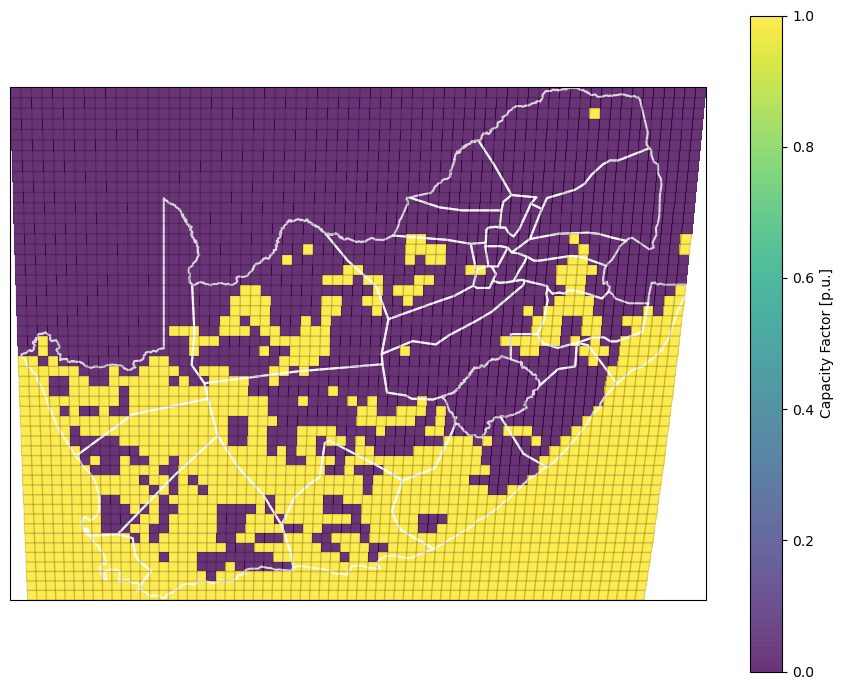

In [30]:
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
capacity_factor.name = 'Capacity Factor'
capacity_factor.plot(ax=ax, transform=plate(), alpha=0.8)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
#ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

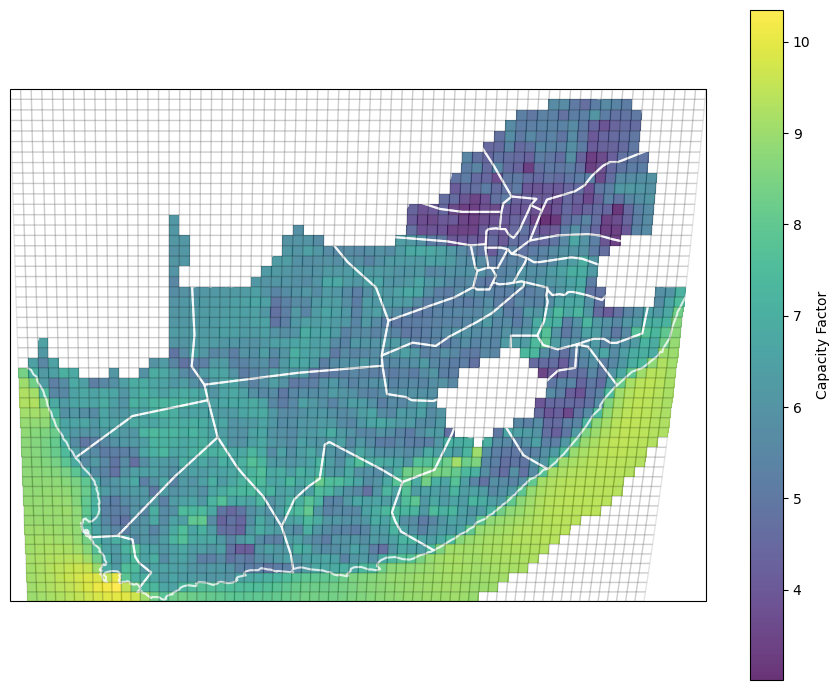

In [31]:
ws_mean=0*capacity_factor.copy()
ws_mean.data=cell_ws_mean.values

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
ws_mean.name = 'Capacity Factor'
ws_mean.plot(ax=ax, transform=plate(), alpha=0.8)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
#ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

In [32]:
era5_wnd100m

lon    lat   wnd100m
time                y      x                            
2012-01-01 00:00:00 -34.75 16.50  16.50 -34.75  7.997329
                           16.75  16.75 -34.75  7.818984
                           17.00  17.00 -34.75  7.596214
                           17.25  17.25 -34.75  7.457885
                           17.50  17.50 -34.75  7.265874
...                                 ...    ...       ...
2013-01-01 23:00:00 -22.25 31.75  31.75 -22.25  7.458905
                           32.00  32.00 -22.25  6.984139
                           32.25  32.25 -22.25  5.965362
                           32.50  32.50 -22.25  5.119706
                           32.75  32.75 -22.25  4.579890

[29647728 rows x 3 columns]

In [33]:
ws_mean.fillna(era5_wnd100m)

TypeError: cannot provide fill value as a dictionary with fillna on a DataArray

In [ ]:
cell_ws_mean = 0*capacity_factor.to_pandas().copy()
cell_ws_max = 0*capacity_factor.to_pandas().copy()
max_xr = 0*capacity_factor.copy()
min_xr = 0*capacity_factor.copy()
cf_ratio = 0*capacity_factor.copy()

In [ ]:
wind_speed2=cutout.data.wnd100m.to_dataframe()


In [ ]:
src=rasterio.open('../data/bundle/ZAF_wind-speed_100m.tif')
for c in cells.index:
    mm=cells.geometry.bounds.loc[c,:]
    window = rasterio.windows.from_bounds(mm['minx'], mm['miny'], mm['maxx'], mm['maxy'], src.transform)

    box = shapely.geometry.box(mm['minx'], mm['miny'], mm['maxx'], mm['maxy'])
    transform = rasterio.windows.transform(window, src.transform)

    src_data = src.read(1, window=window)
    xpos = cells.loc[c,'x']
    ypos = cells.loc[c,'y']
    cell_ws_max.loc[lon,lat] = src_data.max()
    cell_ws_mean.loc[lon,lat] = src_data.mean()
    wind_speed.loc[(slice(None),ypos,xpos),'wnd100m']*=(src_data.mean()/wind_speed.loc[(slice(None),ypos,xpos),'wnd100m'].mean())
  
    print(c)

In [ ]:
ds=wind_speed.to_xarray()

In [ ]:
ds

In [ ]:
ds.chunk(cutout.chunks).wnd100m.data

In [ ]:
ds.chunk(cutout.chunks).wnd100m

In [ ]:
cutout.data.wnd100m

In [ ]:
cutout.data.wnd100m.data=ds.chunk(cutout.chunks).wnd100m.data

In [ ]:
cutout.data.wnd100m.to_dataframe()

In [ ]:
capacity_factor2 = cutout.wind(turbine='Vestas_V112_3MW',capacity_factor=True)

In [ ]:
capacity_factor2.plot()

In [ ]:
wind_speed.fillna(0).loc[(slice(None),-33,20.5),'wnd100m'].plot()
wind_speed2.loc[(slice(None),-33,20.5),'wnd100m'].plot()

In [ ]:
cutout.wind

In [ ]:
wind_speed.loc[(cells.loc[c,'x'],cells.loc[c,'y']),'wnd100m']*1.5

In [ ]:
cf_ratio.data=np.divide(capacity_factor.data,cell_mean.fillna(-1).values)

In [ ]:
np.shape(capacity_factor.data)

In [ ]:
from matplotlib.cm import ScalarMappable

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
mean_xr.name = 'Capacity Factor'
mean_xr.plot(ax=ax, transform=plate(), alpha=0.8)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
#ax.outline_patch.set_edgecolor('white')
fig.tight_layout();





In [ ]:
cf_ratio=0*capacity_factor.copy()
cf_ratio.data=mean_xr.data/capacity_factor.data
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
cf_ratio.name = 'Capacity Factor'
cf_ratio.plot(ax=ax, transform=plate(), alpha=0.8, vmin = 0, vmax = 3)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
#ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

In [ ]:
wd =cutout.data.wnd100m.values
names = ['time', 'x', 'y']
index = pd.MultiIndex.from_product([range(s)for s in wd.shape], names=names)
df = pd.DataFrame({'wd': wd.flatten()}, index=index)['wd']
df = df.unstack(level='time').swaplevel().sort_index()

In [ ]:
wind_speed.loc[(16.5,-34.75),'wnd100m'].mean()

In [ ]:
capacity_factor.data[:,2]

In [ ]:
cm_xr2.data[25,25]

In [ ]:
with rasterio.open('../data/bundle/ZAF_capacity-factor_IEC32.tif') as src, rasterio.open('../data/bundle/ZAF_capacity-factor_IEC32e.tif', 'w', **src.meta) as dst:



    for c in cells: 
        resareas_b = resareas.intersects(region.geometry)
        if not resareas_b.any():
            dst.write_band(1, dst_data, window=window)
            stats.append({'mean': 0.})
            continue

        min_max=cells.geometry.bounds
        window = rasterio.windows.from_bounds(min_max['minx'], min_max['miny'], min_max['maxx'], min_max['maxy'], src.transform)

        window = rasterio.windows.from_bounds(min_max['minx'], min_max['miny'], min_max['minxx'], min_max['minxy'], src.transform)
        box = shapely.geometry.box(minx, miny, maxx, maxy)
        transform = rasterio.windows.transform(window, src.transform)

        src_data = src.read(1, window=window)
        dst_data = np.zeros_like(src_data)

        for grid_codes, value in landusetype_percent:
            dst_data.ravel()[np.in1d(src_data.ravel(), grid_codes)] = value

        mask = rasterio.mask.geometry_mask(resareas.loc[resareas_b, 'geometry'], dst_data.shape, transform)
        dst_data = np.ma.array(dst_data, mask=mask, fill_value=0).filled()

        dst.write_band(1, dst_data, window=window)

        stats.extend(rasterstats.zonal_stats(region.geometry, dst_data, affine=transform,
                                             nodata=-999, stats='mean'))

    stats = pd.DataFrame(stats)

    stats['area_ratio'] = stats.pop('mean') / 100
    stats['area'] = regions.to_crs(area_crs).area/1e6 # albert equal area has area in m^2
    stats['available_area'] = stats['area_ratio'] * stats['area']

    if RSA_flag==True:
        area_data = stats.sum()
        area_output = pd.DataFrame(stats.sum(),columns=['RSA']).T
        area_output.loc['area_ratio'] = area_output['available_area']/area_output['area']
        area_output.to_csv(snakemake.output.area)
    else:
        stats.set_index(regions.name).to_csv(snakemake.output.area)

In [ ]:
cap_factors = cutout.pv(panel='CSi', orientation='latitude_optimal', capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
cap_factors.name = 'Capacity Factor'
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

In [ ]:
cutout.wind(turbine='x', smooth=False)